In [3]:
# Zachary Katz
# zachary_katz@mines.edu
# October 2024

# Calculate the inter-event slope for a station over time

# Imports
import os

import src.Catalog.Catalog as Catalog
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la02",]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
#year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]

year_arr = [["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"]]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################

In [4]:
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [14]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

means = []
# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    # Load events in the years, and remove all data that occurs during the event windows

    # Load events

    catalog = []
    year = years[0]
    for event in os.listdir(f"{year}_{year}events_2stas"):
        catalog.append(
            pd.read_csv(f"{year}_{year}events_2stas/{event}", sep="\t", index_col=0)
        )

    sts = [cat["time"].iloc[0] for cat in catalog]
    eds = [cat["time"].iloc[-1] for cat in catalog]

    eds.insert(0, "2010-01-01 00:00:00")
    sts.insert(-1, "2010-12-31 23:59:59")

    la09 = cats[0]
    interevents = []
    for st, et in zip(sts[:], eds[:]):
        # print(st,et)
        # print(la09.data['time'])
        interevent = la09.data[la09.data["time"].between(et, st)]
        if not interevent.empty:
            interevents.append(interevent)

    # Calculate the slope of the interevent data and find the mean
    slopes = []
    for interevent in interevents[:]:
        x = [i.total_seconds() for i in interevent["time"] - interevent["time"].iloc[0]]
        y = interevent["x"].values
        slope = scipy.stats.linregress(x, y)
        slopes.append(slope.slope)

    # fig, ax = plt.subplots()
    # ax.scatter(x,y)
    # line = [xi * slope.slope + slope.intercept for xi in x]
    # ax.plot(x,line, color='red')

    print(np.mean(slopes))
    means.append(np.mean(slopes))

2024-10-22 16:45:12 __main__ INFO: Creating Dataframe for la02
2024-10-22 16:45:35 __main__ INFO: Interpolating la02
2024-10-22 16:45:37 src.Catalog.Catalog INFO: 2010-04-03 04:48:30 2010-04-03 04:50:00 0 days 00:01:30
2024-10-22 16:45:38 src.Catalog.Catalog INFO: 2010-04-29 23:30:00 2010-04-29 23:33:00 0 days 00:03:00
2024-10-22 16:45:38 src.Catalog.Catalog INFO: 2010-04-29 23:33:00 2010-04-29 23:34:30 0 days 00:01:30
2024-10-22 16:45:38 src.Catalog.Catalog INFO: 2010-04-29 23:35:00 2010-04-29 23:36:30 0 days 00:01:30
2024-10-22 16:45:40 src.Catalog.Catalog INFO: 2010-06-17 21:09:30 2010-06-18 03:51:30 0 days 06:42:00
2024-10-22 16:45:40 src.Catalog.Catalog INFO: 2010-07-02 20:13:30 2010-07-02 22:28:30 0 days 02:15:00
2024-10-22 16:45:40 src.Catalog.Catalog INFO: 2010-07-03 07:00:30 2010-07-03 15:41:30 0 days 08:41:00
2024-10-22 16:45:41 src.Catalog.Catalog INFO: 2010-07-04 04:32:00 2010-07-04 10:22:00 0 days 05:50:00
2024-10-22 16:45:41 src.Catalog.Catalog INFO: 2010-07-09 16:27:00 2

5.5877257891281935e-06


2024-10-22 16:46:45 __main__ INFO: Interpolating la02
2024-10-22 16:46:48 src.Catalog.Catalog INFO: 2011-03-23 04:31:00 2011-03-23 04:32:00 0 days 00:01:00
2024-10-22 16:46:51 src.Catalog.Catalog INFO: 2011-06-26 22:10:00 2011-06-26 23:39:30 0 days 01:29:30
2024-10-22 16:46:51 src.Catalog.Catalog INFO: 2011-06-27 01:10:00 2011-06-27 06:10:30 0 days 05:00:30
2024-10-22 16:46:52 src.Catalog.Catalog INFO: 2011-06-27 08:10:30 2011-06-27 14:07:00 0 days 05:56:30
2024-10-22 16:46:52 src.Catalog.Catalog INFO: 2011-06-27 15:30:30 2011-06-27 18:20:00 0 days 02:49:30
2024-10-22 16:46:52 src.Catalog.Catalog INFO: 2011-06-27 19:52:00 2011-06-27 20:43:30 0 days 00:51:30
2024-10-22 16:46:52 src.Catalog.Catalog INFO: 2011-07-01 11:18:00 2011-07-01 11:45:30 0 days 00:27:30
2024-10-22 16:46:52 src.Catalog.Catalog INFO: 2011-07-02 20:20:00 2011-07-02 21:56:30 0 days 01:36:30
2024-10-22 16:46:53 src.Catalog.Catalog INFO: 2011-07-02 22:49:00 2011-07-02 23:45:00 0 days 00:56:00
2024-10-22 16:46:53 src.Cata

5.396767791799992e-06


2024-10-22 16:48:04 __main__ INFO: Interpolating la02
2024-10-22 16:48:04 src.Catalog.Catalog INFO: 2012-01-04 04:46:30 2012-01-04 05:28:30 0 days 00:42:00
2024-10-22 16:48:04 src.Catalog.Catalog INFO: 2012-01-04 23:56:00 2012-01-05 00:00:00 0 days 00:04:00
2024-10-22 16:48:08 src.Catalog.Catalog INFO: 2012-04-29 22:24:30 2012-04-29 22:26:00 0 days 00:01:30
2024-10-22 16:48:09 src.Catalog.Catalog INFO: 2012-06-24 15:40:30 2012-06-24 18:49:00 0 days 03:08:30
2024-10-22 16:48:10 src.Catalog.Catalog INFO: 2012-07-08 19:01:30 2012-07-08 19:13:30 0 days 00:12:00
2024-10-22 16:48:10 src.Catalog.Catalog INFO: 2012-07-08 19:15:00 2012-07-08 19:37:30 0 days 00:22:30
2024-10-22 16:48:10 src.Catalog.Catalog INFO: 2012-07-08 19:38:30 2012-07-08 19:52:00 0 days 00:13:30
2024-10-22 16:48:10 src.Catalog.Catalog INFO: 2012-07-08 19:52:30 2012-07-08 19:59:30 0 days 00:07:00
2024-10-22 16:48:10 src.Catalog.Catalog INFO: 2012-07-08 20:02:30 2012-07-08 20:11:00 0 days 00:08:30
2024-10-22 16:48:11 src.Cata

5.356950524005131e-06


Text(0.5, 0.98, 'Yearly Mean Interevent Slope for LA09')

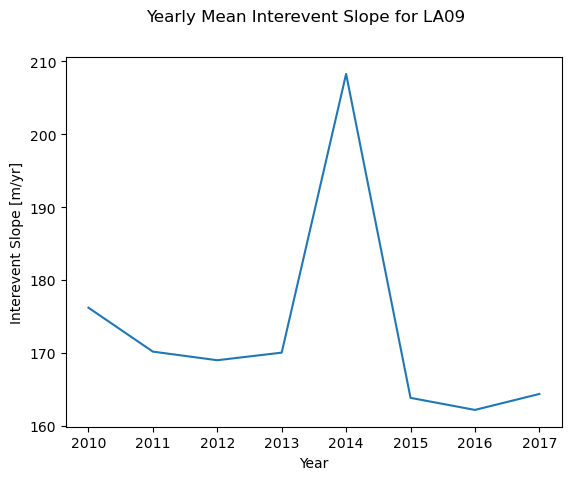

In [15]:
fig, ax = plt.subplots()
SEC_TO_YR = 1 / 60 / 60 / 24 / 365
means_yr = [i / SEC_TO_YR for i in means]  # m/s to m/yr
year_arr_int = [int(i[0]) for i in year_arr]
ax.plot(year_arr_int[:], means_yr[:])
ax.set_xlabel("Year")
ax.set_ylabel("Interevent Slope [m/yr]")
fig.suptitle("Yearly Mean Interevent Slope for LA09")

       longitude   latitude                time  day_of_year  elevation  sats  \
0    -153.862349 -84.247819 2018-01-01 00:00:00     1.000000    95.7903  10.0   
1    -153.862348 -84.247819 2018-01-01 00:00:15     1.000174    95.7882  10.0   
2    -153.862348 -84.247819 2018-01-01 00:00:30     1.000347    95.7757  10.0   
3    -153.862348 -84.247819 2018-01-01 00:00:45     1.000521    95.7855  10.0   
4    -153.862348 -84.247819 2018-01-01 00:01:00     1.000694    95.7844  10.0   
...          ...        ...                 ...          ...        ...   ...   
3386 -153.862371 -84.247819 2018-01-01 14:06:30     1.587847    95.8027  12.0   
3387 -153.862371 -84.247819 2018-01-01 14:06:45     1.588021    95.7991  12.0   
3388 -153.862371 -84.247819 2018-01-01 14:07:00     1.588194    95.7973  12.0   
3389 -153.862372 -84.247819 2018-01-01 14:07:15     1.588368    95.8304  12.0   
3390 -153.862372 -84.247819 2018-01-01 14:07:30     1.588542    95.7792  12.0   

      GDOP              x  

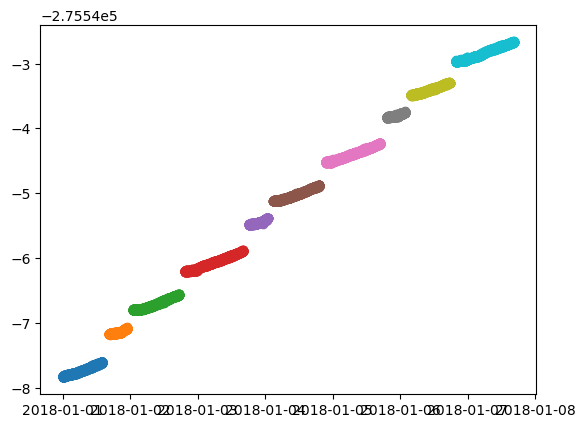

In [47]:
# TEST PLOTTING OF INTEREVENTS TO SEE SLOPE
fig, ax = plt.subplots()
for interevent in interevents[:10]:
    print(interevent)
    ax.scatter(interevent["time"], interevent["x"])